<a href="https://colab.research.google.com/github/EiffL/AstroHackWeek2019/blob/master/day4_ml/TFP_mass_estimate_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 Matthew Ho, Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");


# Estimating Galaxy Cluster Masses with TensorFlow Probability

Authors: 
  - [@maho3](https://github.com/maho3) (Matt Ho)
  - [@EiffL](https://github.com/EiffL) (Francois Lanusse)

### Overview

In this tutorial, we learn how to combine Keras and TensorFlow Probability to estimate the masses of galaxy clusters using velocity dispersion measurements. See for instance [Ho et al. (2019)](https://arxiv.org/abs/1902.05950) for a state of the art machine learning approach to this problem.

The context for this problem is to be able to build robust mass estimates for 
galaxy clusters, simply by using information from their galaxy members. And in 
particular line of sight velocity information which can be obtained by spectroscopy.

As we will see, despite combining a number of input features, the model prediction always has some uncertainties and it is important to properly account for them to avoid biasing results.

### Learning objectives

In this notebook, we will learn:
*   The limits of simple regression which can lead to biases.
*   How to use TensorFlow Probability to build a probabilistic model.
*   How to use the model probability predicted by the model to eliminate usual biases.


In [1]:
#@title Imports and Utility functions { display-mode: "form" }
%pylab inline

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

def binned_plot(X, Y, n=10, percentiles=[35, 50], ax=None, **kwargs):
    # Calculation
    calc_percent = []
    for p in percentiles:
        if p < 50:
            calc_percent.append(50-p)
            calc_percent.append(50+p)
        elif p == 50:
            calc_percent.append(50)
        else:
            raise Exception('Percentile > 50')

    bin_edges = np.linspace(X.min()*0.9999, X.max()*1.0001, n+1)

    dtype = [(str(i), 'f') for i in calc_percent]
    bin_data = np.zeros(shape=(n,), dtype=dtype)

    for i in range(n):
        y = Y[(X >= bin_edges[i]) & (X < bin_edges[i+1])]

        if len(y) == 0:
            continue

        y_p = np.percentile(y, calc_percent)

        bin_data[i] = tuple(y_p)

    # Plotting
    if ax is None:
        f, ax = plt.subplots()

    bin_centers = [np.mean(bin_edges[i:i+2]) for i in range(n)]
    for p in percentiles:
        if p == 50:
            ax.plot(bin_centers, bin_data[str(p)], **kwargs)
        else:
            ax.fill_between(bin_centers,
                            bin_data[str(50-p)],
                            bin_data[str(50+p)],
                            alpha=0.2,
                            **kwargs)

    return bin_data, bin_edges


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Understanding the data

In [4]:
#@title Loading dataset.
#from google.colab import auth
from astropy.table import Table

#auth.authenticate_user()
bucket_name='ahw2019'

!gsutil cp gs://{bucket_name}/halo_mass_regression/'Rockstar_UM_z=0.117_contam_summary.fits' contam_summary.fits

print('Download complete')

data = Table.read('contam_summary.fits')

Copying gs://ahw2019/halo_mass_regression/Rockstar_UM_z=0.117_contam_summary.fits...
\ [1 files][ 59.8 MiB/ 59.8 MiB]                                                
Operation completed over 1 objects/59.8 MiB.                                     
Download complete


Text(0.5, 0, '$\\log[M_{200c}\\ (h^{-1}M_\\odot)]$')

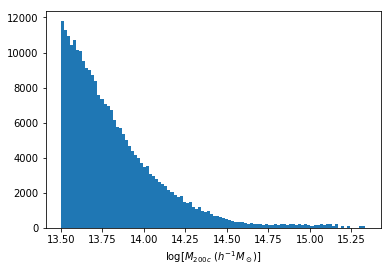

In [5]:
# Let's check the mass distribution in this sample
hist(log10(data['M200c']),100)
xlabel(r'$\log[M_{200c}\ (h^{-1}M_\odot)]$')

Text(0, 0.5, '$\\log_{10}[N_\\mathrm{gal}]$')

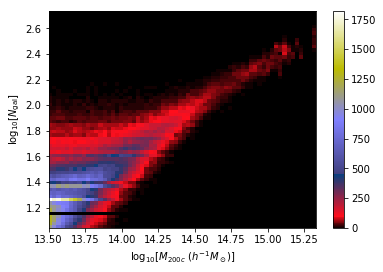

In [6]:
hist2d(log10(data['M200c']), log10(data['Ngal']),64,cmap='gist_stern');
plt.colorbar()
xlabel(r'$\log_{10}[M_{200c}\ (h^{-1}M_\odot)]$')
ylabel(r'$\log_{10}[N_\mathrm{gal}]$')

This plot shows the scaling relation between mass and number of cluster members

Text(0, 0.5, '$\\log_{10}[\\sigma_v\\ (km\\ s^{-1})]$')

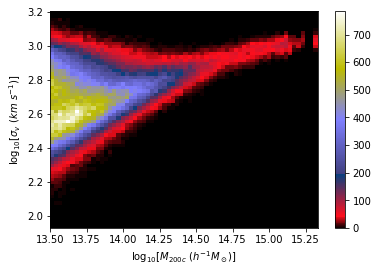

In [7]:
hist2d(log10(data['M200c']), log10(data['sigv']),64,cmap='gist_stern');
plt.colorbar()
xlabel(r'$\log_{10}[M_{200c}\ (h^{-1}M_\odot)]$')
ylabel(r'$\log_{10}[\sigma_v\ (km\ s^{-1})]$')

This plot illustrates the scaling relation between mass and the velocity dispersion of cluster members.

In [0]:
# Preprocessing some features
data['LogNgal'] = np.log10(data['Ngal'])
data['Logsigv'] = np.log10(data['sigv'])
data['logmass'] = np.log10(data['M200c'])

# Preparing data set
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Split into train and test
inds_random = permutation(len(data))
data_train = data[inds_random[:200000]]
data_test = data[inds_random[200000:]]

# Features to use for regression
X = data[['LogNgal', # log richness
          'Logsigv', # log velocity dispersion
          'R_mean', 'R_std', 'R_skew', 'R_kurt', # descriptive features of cluster member projected radius distribution
          'm_mean', 'm_std', 'm_skew', 'm_kurt', # " of member stellar mass distribution
          'v_mean', 'v_std', 'v_skew', 'v_kurt'  # " of member LOS velocity distribution
         ]].to_pandas().values

X_train = X[inds_random[:200000]]
X_test = X[inds_random[200000:]]

scaler = MinMaxScaler().fit(data['logmass'].reshape((-1,1)))
feature_scaler = StandardScaler().fit(X_train)

X_train = feature_scaler.transform(X_train)
Y_train = np.clip(scaler.transform(data_train['logmass'].reshape((-1,1))), 1e-5,1-1e-5)

X_test = feature_scaler.transform(X_test)
Y_test = np.clip(scaler.transform(data_test['logmass'].reshape((-1,1))),1e-5,1-1e-5)

Y_true = data_test['logmass']

## First approach: Regression

We begin by implementing a simple regression model using a mean squared error loss. This is the standard approach taken by most ML papers on this problem.


In [0]:
regression_model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(14,)),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='tanh'),
    keras.layers.Dense(units=1)
])

callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 2 else 0.0001)

regression_model.compile(loss='mean_squared_error', optimizer='adam', metrics=[])

In [0]:
regression_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1920      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 26,753
Trainable params: 26,753
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = regression_model.fit(X_train, Y_train, epochs=5, batch_size=100, callbacks=[callback])

Epoch 1/5
200000/200000 [==============================] - 4s 19us/sample - loss: 0.0069
Epoch 2/5
200000/200000 [==============================] - 4s 18us/sample - loss: 0.0053
Epoch 3/5
200000/200000 [==============================] - 4s 18us/sample - loss: 0.0050
Epoch 4/5
200000/200000 [==============================] - 4s 19us/sample - loss: 0.0049
Epoch 5/5
200000/200000 [==============================] - 4s 19us/sample - loss: 0.0049


Now that the model is trained, let's exrtact some predictions:

In [0]:
Y_pred = scaler.inverse_transform(regression_model.predict(X_test)).squeeze()

Text(0, 0.5, '$\\epsilon$')

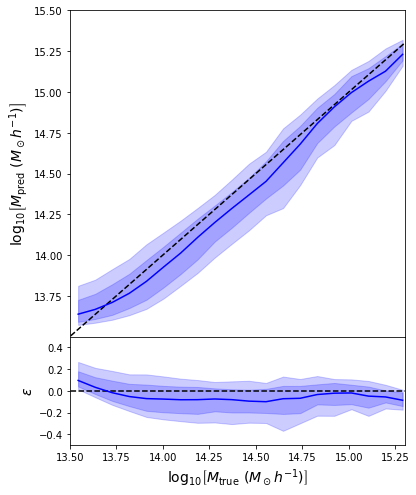

In [0]:
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

ax1.plot(np.arange(13,16,0.1),np.arange(13,16,0.1),'k--')
_ = binned_plot(Y_true, 
                Y_pred, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax1)

ax1.set_xlim(13.5,15.3)
ax1.set_ylim(13.5,15.3)
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (M_\odot h^{-1})\right]$', fontsize=14)

ax2 = f.add_subplot(gs[1,0])

ax2.plot(np.arange(13,16,0.1),[0]*30,'k--')
_ = binned_plot(Y_true, 
                Y_pred - Y_true, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax2)
ax2.set_xlim(13.5,15.3)
ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (M_\odot h^{-1})\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14)

We see a significant bias... What could be the cause? What did we do wrong?

## Second approach: Probabilistic Modelling

By now we now that using a MSE can lead to biased estimates. How about we switch to a model of the full posterior, that should fix our problems!


In [0]:
num_components = 16
event_shape = [1]

model = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(14,)),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='tanh'),
    #keras.layers.Dense(tfp.layers.MixtureNormal.params_size(num_components, event_shape)),
    #tfp.layers.MixtureNormal(num_components, event_shape)
    keras.layers.Dense(units=num_components*3),
    tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=tf.expand_dims(t[..., :num_components], -2)),
                              components_distribution=tfd.Beta(1 + tf.nn.softplus(tf.expand_dims(t[..., num_components:2*num_components], -2)),
                                                               1 + tf.nn.softplus(tf.expand_dims(t[..., 2*num_components:],-2)))), 1))
    ])

negloglik = lambda y, p_y: -p_y.log_prob(y)

callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)

model.compile(loss=negloglik, optimizer='adam', metrics=[])

W0828 16:09:30.593684 140694165649280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/internal/distribution_util.py:493: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=100, callbacks=[callback])

Epoch 1/10
200000/200000 [==============================] - 5s 25us/sample - loss: -1.3196
Epoch 2/10
200000/200000 [==============================] - 5s 25us/sample - loss: -1.4084
Epoch 3/10
200000/200000 [==============================] - 5s 24us/sample - loss: -1.4243
Epoch 4/10
200000/200000 [==============================] - 5s 24us/sample - loss: -1.4350
Epoch 5/10
200000/200000 [==============================] - 5s 24us/sample - loss: -1.4416
Epoch 6/10
200000/200000 [==============================] - 5s 24us/sample - loss: -1.4574
Epoch 7/10
200000/200000 [==============================] - 5s 24us/sample - loss: -1.4596
Epoch 8/10
200000/200000 [==============================] - 5s 24us/sample - loss: -1.4609
Epoch 9/10
200000/200000 [==============================] - 5s 25us/sample - loss: -1.4618
Epoch 10/10
200000/200000 [==============================] - 5s 25us/sample - loss: -1.4628


Text(0, 0.5, 'Loss')

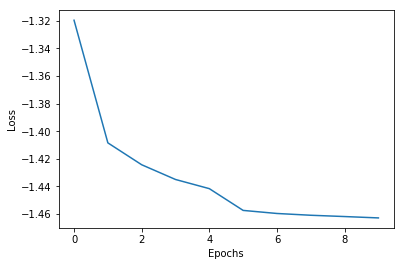

In [0]:
plot(history.history['loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')

In [0]:
# Computing mean of the posterior, and output of the previous regression model
# for comparison
Y_pred = scaler.inverse_transform(model(X_test).mean().numpy()).squeeze()
Y_pred_reg = scaler.inverse_transform(regression_model.predict(X_test)).squeeze()

Text(0, 0.5, '$\\epsilon$')

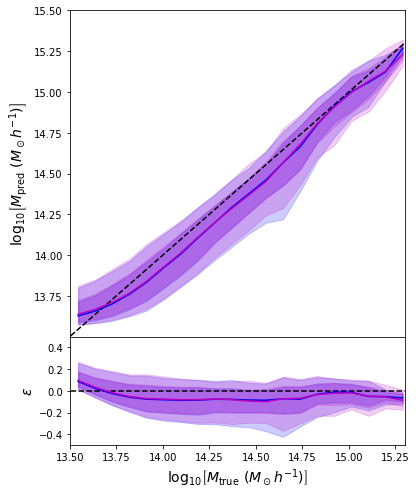

In [0]:
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

ax1.plot(np.arange(13,16,0.1),np.arange(13,16,0.1),'k--')
_ = binned_plot(Y_true, 
                Y_pred, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax1)
_ = binned_plot(Y_true, 
                Y_pred_reg, 
                n=20, percentiles=[35,45,50], 
                color='m', ax=ax1)

ax1.set_xlim(13.5,15.3)
ax1.set_ylim(13.5,15.3)
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (M_\odot h^{-1})\right]$', fontsize=14)


ax2 = f.add_subplot(gs[1,0])

ax2.plot(np.arange(13,16,0.1),[0]*30,'k--')
_ = binned_plot(Y_true, 
                Y_pred - Y_true, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax2)
_ = binned_plot(Y_true, 
                Y_pred_reg - Y_true, 
                n=20, percentiles=[35,45,50], 
                color='m', ax=ax2)
ax2.set_xlim(13.5,15.3)
ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (M_\odot h^{-1})\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14)

Wait.... What? We get the same answer despite our fancy model. Why is that?

### What is my prior?

As we have seen today, the output of the Mixture Density Network can be seen as a posterior distribution under the prior defined by the distribution of masses in the training set. 

Let's have a look at this distribution $p(M_{200c})$

In [0]:
import scipy.stats
hist = np.histogram(scaler.inverse_transform(Y_train), 64)
prior = scipy.stats.rv_histogram(hist)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, '$\\log_{10}[M_{200c}\\ (h^{-1}M_\\odot)]$')

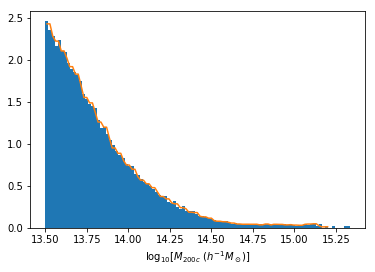

In [0]:
plt.hist(scaler.inverse_transform(Y_train), 100, normed=True);
x = linspace(13.51,15.2,100)
plot(x, prior.pdf(x))
xlabel(r'$\log_{10}[M_{200c}\ (h^{-1}M_\odot)]$')

So it's definitely not flat, as a matter of fact, it's heavily  preferring lower mass halos. This could explain why our posterior masses are systematically predicted low when we take the mean of the posterior.

Let's compute the mass PDF predicted by the model for  all clusters in the training set.

In [0]:
# This returns the distribution q(M | x) for all clusters
outputs = model(X_test)
xt = scaler.transform(x.reshape((-1,1)))
logps = []

for i in range(len(x)):
    logps.append(outputs.log_prob(xt[i]).numpy())
logps = np.stack(logps)

Now that we have the prior and posterior distributions, we can replace the training set prior $\tilde{p}$ by a flat prior $p$ simply by using the formula:
$$ q(M_{200c} | x ) \propto \frac{\tilde{p}(M_{200c})}{p(M_{200c})} p(M_{200c} | x) $$

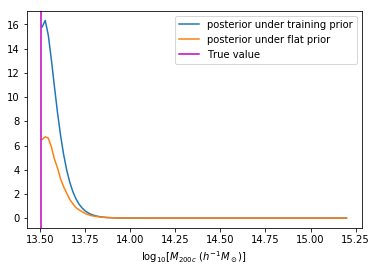

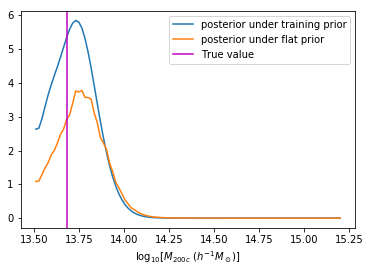

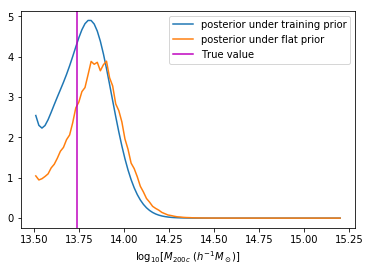

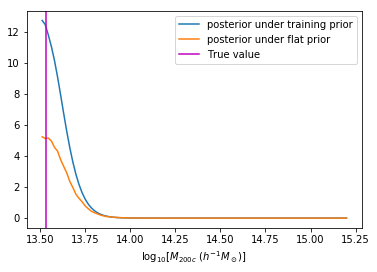

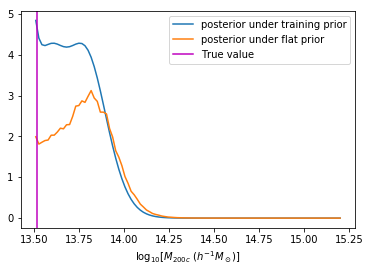

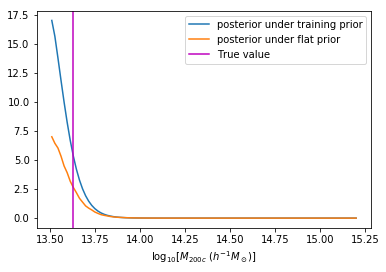

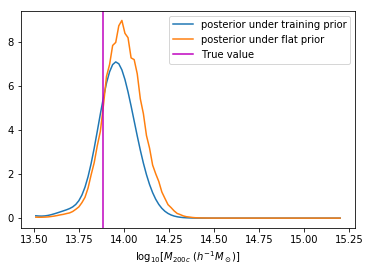

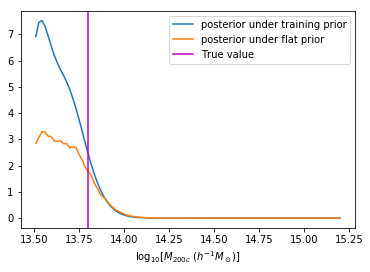

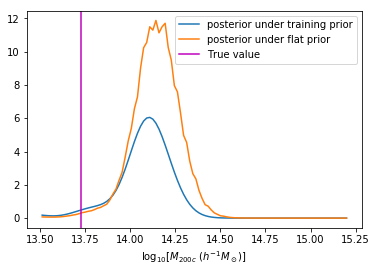

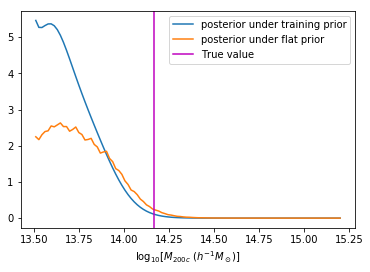

In [0]:
for i in range(10):
  figure()
  plot(x, np.exp(logps[:,-i]), label='posterior under training prior')
  plot(x, np.exp(logps[:,-i])/prior.pdf(x), label='posterior under flat prior')
  axvline(Y_true[-i], color='m', label='True value')
  xlabel(r'$\log_{10}[M_{200c}\ (h^{-1}M_\odot)]$')
  legend()

Yep, the posteriors tend to move  to the right!

Let's compute this 'corrected posterior' for all clusters, and use the new posterior mean as our point estimate of the mass

In [0]:
from scipy.integrate import simps
corrected_posterior = np.exp(logps)/(prior.pdf(x).reshape((-1,1)))

In [0]:
y_pred_prior_mean = simps(x.reshape((-1,1))*corrected_posterior, x,axis=0)/simps(corrected_posterior,x,axis=0 )  

Text(0, 0.5, '$\\epsilon$')

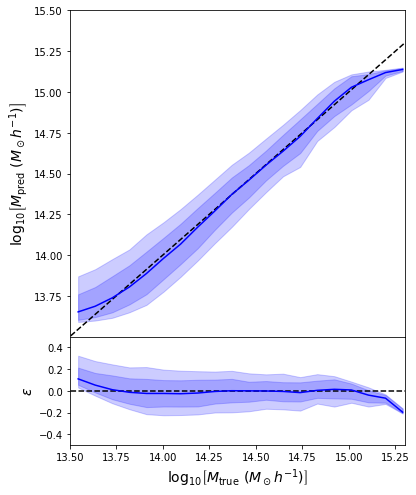

In [0]:
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

ax1.plot(np.arange(13,16,0.1),np.arange(13,16,0.1),'k--')
_ = binned_plot(Y_true, 
                y_pred_prior_mean, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax1)

ax1.set_xlim(13.5,15.3)
ax1.set_ylim(13.5,15.3)
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (M_\odot h^{-1})\right]$', fontsize=14)


ax2 = f.add_subplot(gs[1,0])

ax2.plot(np.arange(13.,16,0.1),[0]*30,'k--')
_ = binned_plot(Y_true, 
                y_pred_prior_mean - Y_true, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax2)

ax2.set_xlim(13.5,15.3)
ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (M_\odot h^{-1})\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14)

We got rid of most of bias \o/ But what's going on at the edges???


### Is the posterior mean a good summary?

Let's have a look at the predicted posterior for objects on the edge of the distribution to understand what is going on.

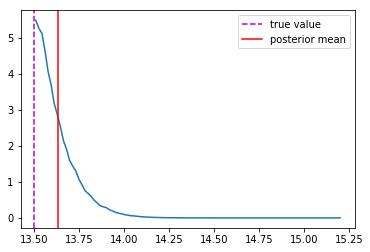

In [0]:
m = Y_true < 13.55
plot(x, corrected_posterior[:,m][:,0])
axvline(Y_true[m][0], ls='--', label='true value', color='m')
axvline(y_pred_prior_mean[m][0], label='posterior mean', color='r')
legend()

Ok, so the problem was that the posterior distribution is not symmetrical near the edges, so the posterior mean ends up being very biased, what we want is the 
posterior mode!

In [0]:
y_pred_mode = x[np.exp(corrected_posterior).argmax(axis=0)]

Text(0, 0.5, '$\\epsilon$')

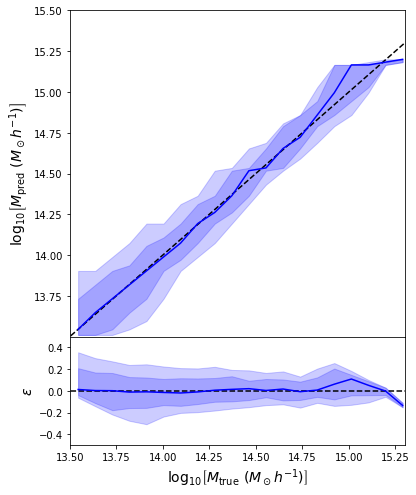

In [0]:
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

ax1.plot(np.arange(13,16,0.1),np.arange(13,16,0.1),'k--')
_ = binned_plot(Y_true, 
                y_pred_mode, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax1)

ax1.set_xlim(13.5,15.3)
ax1.set_ylim(13.5,15.3)
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (M_\odot h^{-1})\right]$', fontsize=14)

ax2 = f.add_subplot(gs[1,0])

ax2.plot(np.arange(13,16,0.1),[0]*30,'k--')
_ = binned_plot(Y_true, 
                y_pred_mode - Y_true, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax2)
ax2.set_xlim(13.5,15.3)
ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (M_\odot h^{-1})\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14)

Tadaa! Works nicely, especially at lower masses, but not perfect at higher masses? 
The main reason is that we are correcting a posterior the prior used during training, a better strategy would be to train the model on a dataset with flat prior masses, as was done in Ho et al. (2019).
